In [84]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os,sys
from image_helpers import *
from features import *
from classification import *
from cost import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [85]:
#Global variables
image_dir = "../training/images/"
gt_dir = "../training/groundtruth/"
files = os.listdir(image_dir)

In [86]:
# Loaded a set of images with their groundtruth
imgs, gt_imgs = load_n_images_groundtruth(image_dir, gt_dir, 20)
n = 10 # Only use 10 images for training

Image size = 400,400


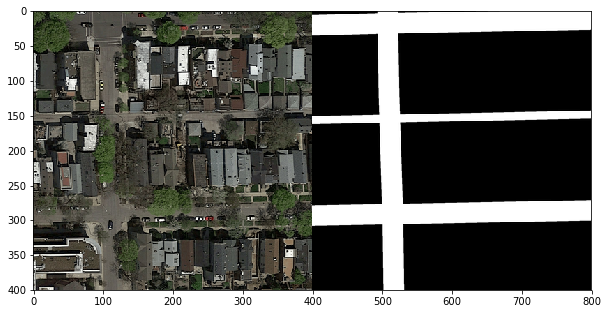

In [87]:
print('Image size = ' + str(imgs[0].shape[0]) + ',' + str(imgs[0].shape[1]))

# Show first image and its groundtruth image
cimg = concatenate_images(imgs[0], gt_imgs[0])
fig1 = plt.figure(figsize=(10, 10))
plt.imshow(cimg, cmap='Greys_r')

In [88]:
# Extract patches from input images
patch_size = 16 # each patch is 16*16 pixels

img_patches = [img_crop(imgs[i], patch_size, patch_size) for i in range(n)]
gt_patches = [img_crop(gt_imgs[i], patch_size, patch_size) for i in range(n)]

# Linearize list of patches
img_patches = np.asarray([img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))])
gt_patches =  np.asarray([gt_patches[i][j] for i in range(len(gt_patches)) for j in range(len(gt_patches[i]))])

In [89]:
# Compute features for each image patch
foreground_threshold = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch

X = np.asarray([extract_features_8d(img_patches[i],i,patch_size,400) for i in range(len(img_patches))])
Y = np.asarray([value_to_class(np.mean(gt_patches[i]), foreground_threshold) for i in range(len(gt_patches))])

In [90]:
# Print feature statistics

print('Computed ' + str(X.shape[0]) + ' features')
print('Feature dimension = ' + str(X.shape[1]))
print('Number of classes = ' + str(np.max(Y)))

Y0 = [i for i, j in enumerate(Y) if j == 0]
Y1 = [i for i, j in enumerate(Y) if j == 1]
print('Class 0: ' + str(len(Y0)) + ' samples')
print('Class 1: ' + str(len(Y1)) + ' samples')

Computed 6250 features
Feature dimension = 8
Number of classes = 1
Class 0: 4304 samples
Class 1: 1946 samples


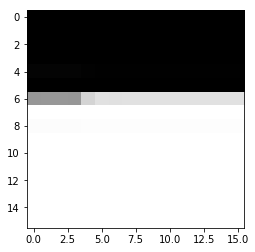

In [91]:
# Display a patch that belongs to the foreground class
plt.imshow(gt_patches[Y1[3]], cmap='Greys_r')

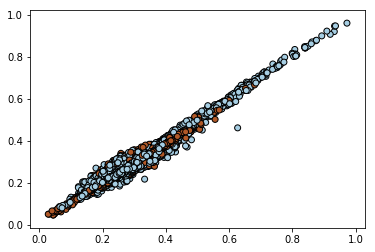

In [92]:
# Plot 2d features using groundtruth to color the datapoints
plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolors='k', cmap=plt.cm.Paired)

In [93]:
# train a logistic regression classifier

#from sklearn import linear_model

# we create an instance of the classifier and fit the data
#logreg = linear_model.LogisticRegression(C=1e5, class_weight="balanced")
#logreg.fit(X, Y)
# train a logistic regression classifier

from sklearn import svm

# we create an instance of the classifier and fit the data
logreg = svm.SVC(C=1e5, class_weight="balanced")
logreg.fit(X, Y)

SVC(C=100000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [94]:
# Predict on the training set
Z = logreg.predict(X)

# Get non-zeros in prediction and grountruth arrays
Zn = np.nonzero(Z)[0]
Yn = np.nonzero(Y)[0]

TPR = len(list(set(Yn) & set(Zn))) / float(len(Z))
print('True positive rate = ' + str(TPR))

True positive rate = 0.31136


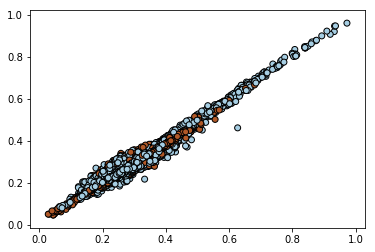

In [95]:
# Plot features using predictions to color datapoints
plt.scatter(X[:, 0], X[:, 1], c=Z, edgecolors='k', cmap=plt.cm.Paired)

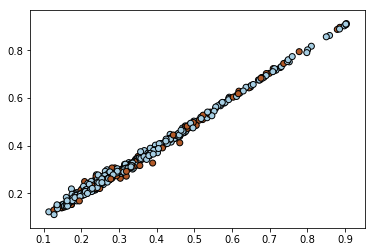

In [96]:
# Run prediction on the img_idx-th image
img_idx = 12

Xi = extract_img_features_8d(image_dir + files[img_idx], patch_size)
Zi = logreg.predict(Xi)
plt.scatter(Xi[:, 0], Xi[:, 1], c=Zi, edgecolors='k', cmap=plt.cm.Paired)

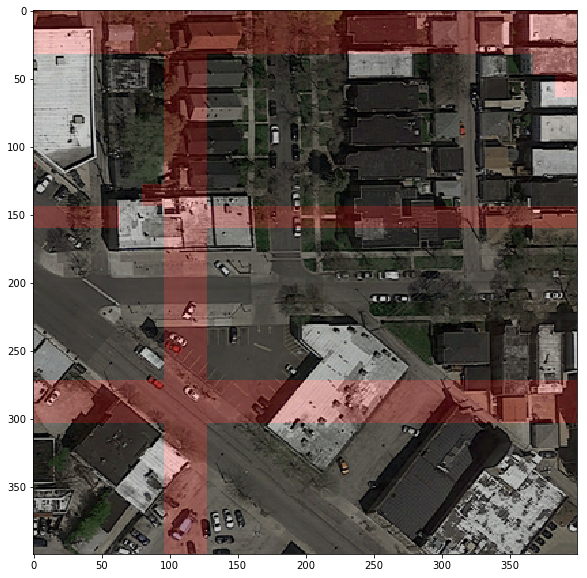

In [97]:
# Display prediction as an image

w = gt_imgs[img_idx].shape[0]
h = gt_imgs[img_idx].shape[1]
predicted_im = label_to_img(w, h, patch_size, patch_size, Zi)
cimg = concatenate_images(imgs[img_idx], predicted_im)
fig1 = plt.figure(figsize=(10, 10)) # create a figure with the default size 
plt.imshow(cimg, cmap='Greys_r')

new_img = make_img_overlay(imgs[img_idx], predicted_im)

plt.imshow(new_img)


In [98]:
expected_color_mask = load_image(gt_dir + files[img_idx])

In [99]:
print(compute_accuracy(imgs[img_idx], predicted_im, expected_color_mask, patch_size, foreground_threshold))

0.5744
